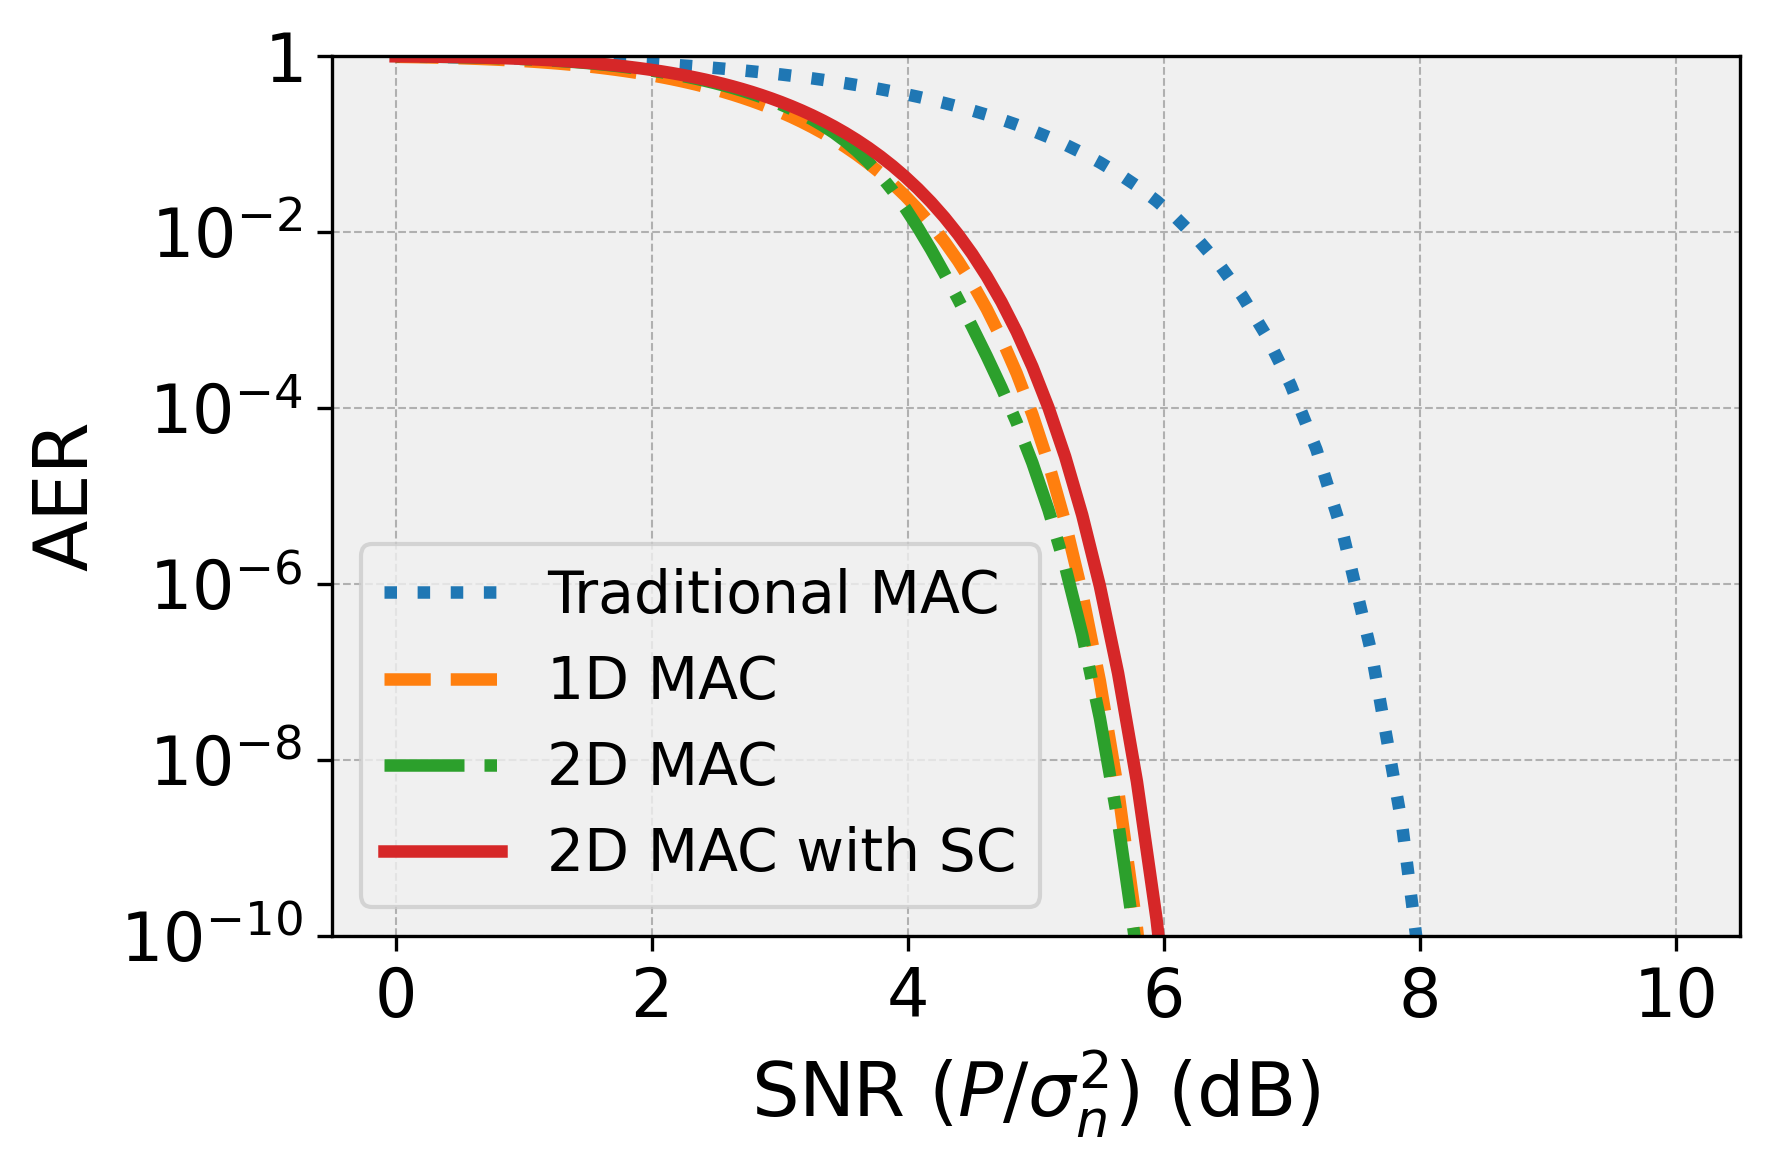

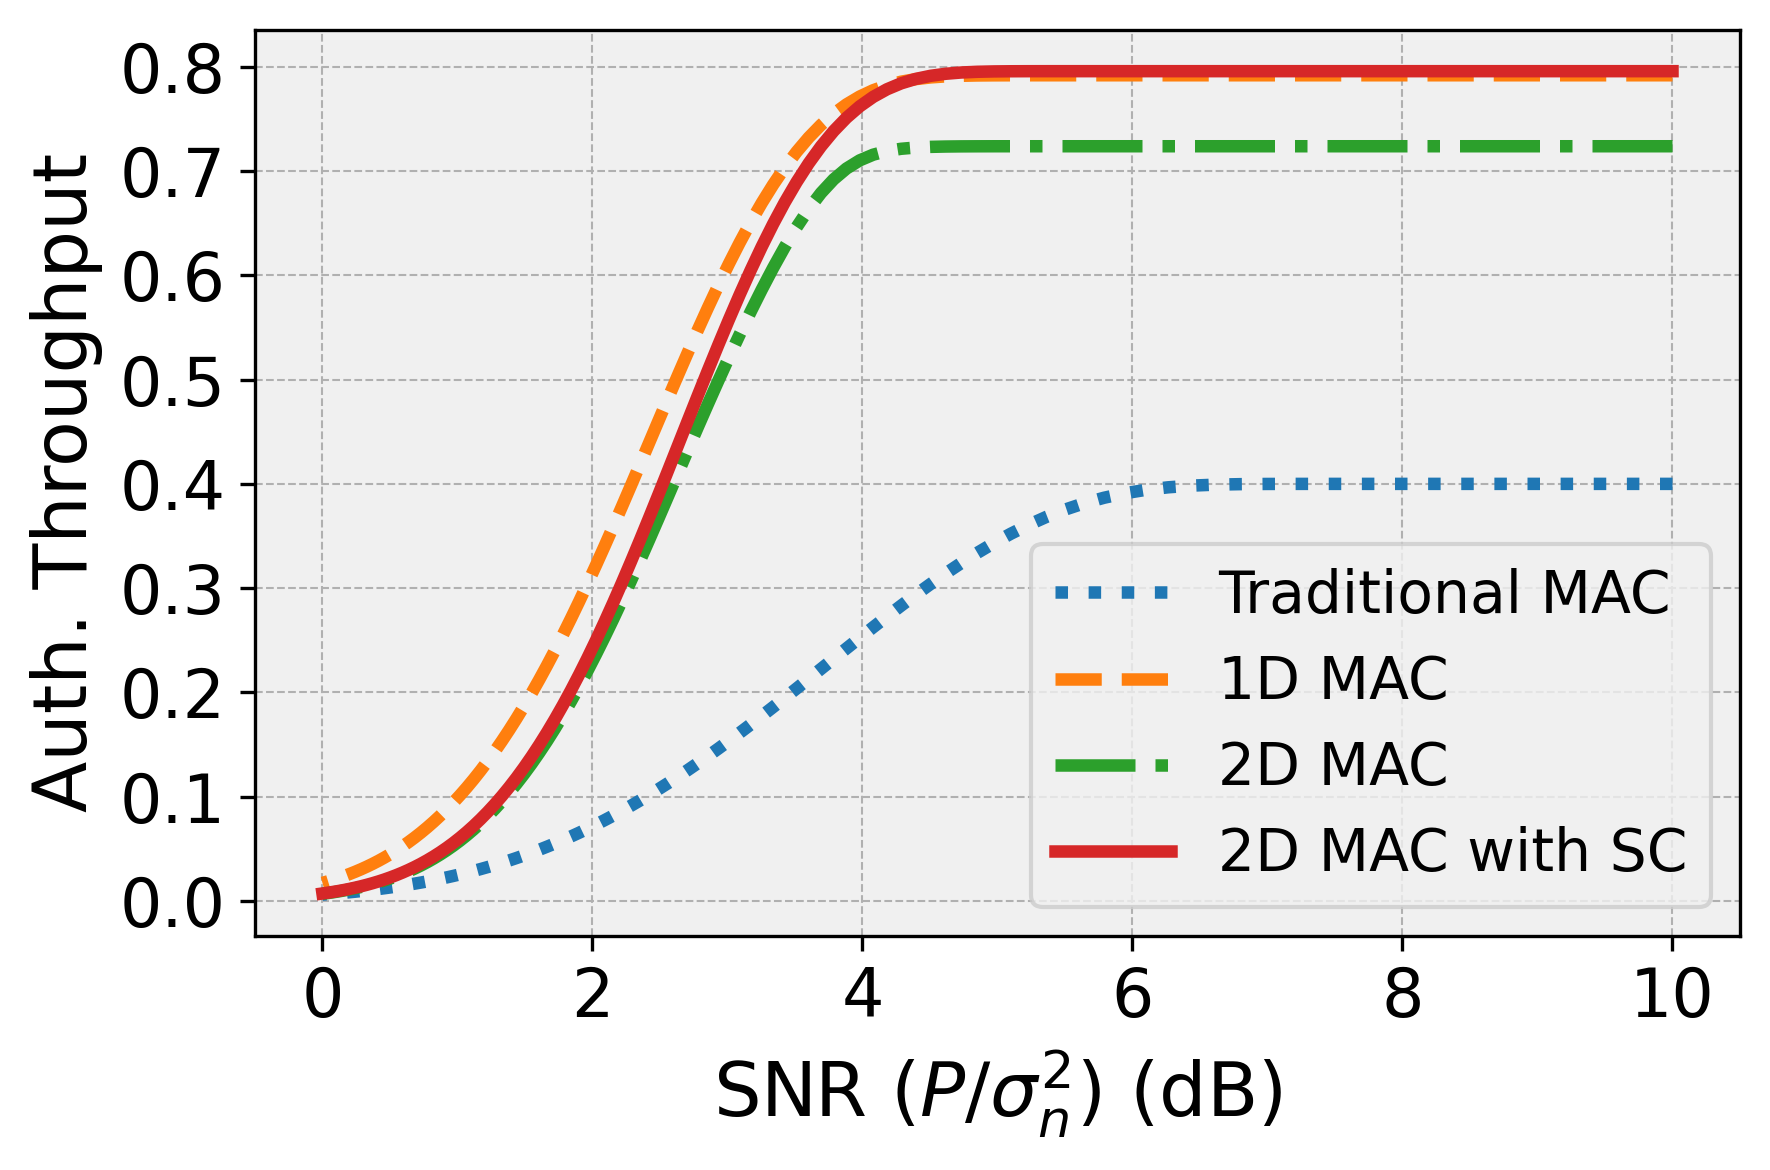

<Figure size 3000x1800 with 0 Axes>

<Figure size 3000x1800 with 0 Axes>

In [75]:
import numpy as np
from scipy.special import erfc

# Q-function using erfc for Gaussian distribution
def Q(x):
    return 0.5 * erfc(x / np.sqrt(2))

# Calculate gamma values for tag and message based on alpha, signal power P, and noise power sigma_n
def calculate_gamma(alpha, P, sigma_n):
    gamma_t = (alpha * P) / ((1 - alpha) * P + sigma_n)
    gamma_m = ((1 - alpha) * P) / (alpha * P + sigma_n)
    return gamma_t, gamma_m

# Calculate Bit Error Rate (BER) p_t and p_m based on gamma_t and gamma_m
def calculate_p(gamma):
    return Q(np.sqrt(2 * gamma))

# Define C' and C'' based on p_t and p_m using the channel capacity formula
def calculate_C(p):
    return 1 + p * np.log2(p) + (1 - p) * np.log2(1 - p) 

# Calculating Pe for tag and message lengths based on the provided formulas
def calculate_Pe(R, p, C, length, y=1):
    if y == 1:
        return Q(np.sqrt(length / (p * (1 - p))) * ((C - R) / np.log2((1 - p) / p)))
    else:
        return Q(np.sqrt(y * length / (p * (1 - p))) * ((C - R*(t/y*m)) / np.log2((1 - p) / p)))

# Calculate AER based on the provided formula
def calculate_AER(Pe_m_prime, Pe_t_prime, Pe_t, x, y):
    term1 = Pe_m_prime
    term2 = (1 - (1 - Pe_m_prime)**(y-1) * (1 - Pe_t_prime))
    term3 = (1 - (1 - Pe_m_prime)**(x-1) * (1 - Pe_t))
    AER = term1 + term2 * term3 * (1 - Pe_m_prime)
    return AER

def calculate_A(Pe_m_prime, Pe_t_prime, Pe_t, x, y):
    term2 = (1 - (1 - Pe_m_prime)**(y-1) * (1 - Pe_t_prime))
    term3 = (1 - (1 - Pe_m_prime)**(x-1) * (1 - Pe_t))
    A = term2 * term3
    return (1-A)*(1-Pe_m_prime)

# Arbitrary values for parameters
P = 10  # Signal power
sigma_ns = np.linspace(1,10,100) # Noise power
alpha_scheme_1 = 0  # Alpha for scheme 1
alpha_scheme_2 = 0.005  # Alpha for scheme 2

R = 0.8 # Transmission rate
t = 32  # Length of the tag
m = 32  # Length of the message
x = 5  # Arbitrary parameter
y = 100 # Arbitrary parameter


AER = {"AER_scheme_trad":[], "AER_scheme_0":[], "AER_scheme_1":[], "AER_scheme_2":[]}
A_term = {"A_scheme_trad":[], "A_scheme_0":[], "A_scheme_1":[], "A_scheme_2":[]}
for sigma_n in sigma_ns:
    # Scheme 0 calculations
    P_trad = P#
    gamma_t_trad, gamma_m_trad = calculate_gamma(0, P_trad, sigma_n)
    p_trad = calculate_p(gamma_m_trad)
    C_trad = calculate_C(p_trad)
    Pe_t_trad = calculate_Pe(R, p_trad, C_trad, t)
    Pe_m_trad = calculate_Pe(R, p_trad, C_trad, m)

    AER_trad = 1 - (1 - Pe_t_trad) * ((1 - Pe_m_trad))
    A_term_trad = (1 - Pe_t_trad) * (1 - Pe_m_trad)


    #scheme 0 calculation
    P_0 = P * (x*y*m + x*y*t)/(x*y*m + y*t)#
    gamma_t_0, gamma_m_0 = calculate_gamma(0, P_0, sigma_n)
    p_0 = calculate_p(gamma_m_0)
    C_0 = calculate_C(p_0)
    Pe_t_0 = calculate_Pe(R, p_0, C_0, t)
    Pe_m_0 = calculate_Pe(R, p_0, C_0, m)
    AER_scheme_0 = 1-(1-Pe_t_0)*((1-Pe_m_0)**(x-1))
    A_term_scheme_0 = ((1-Pe_t_0)*(1-Pe_m_0)**(x-1))



    # Scheme 1 calculations
    P_1 = P * (x*y*m + x*y*t)/(x*y*m + (x+y)*t)#
    gamma_t_1, gamma_m_1 = calculate_gamma(alpha_scheme_1, P_1, sigma_n)
    p_1 = calculate_p(gamma_m_1)
    C_1 = calculate_C(p_1)
    Pe_t_1 = calculate_Pe(R, p_1, C_1, t)
    Pe_m_1 = calculate_Pe(R, p_1, C_1, m)
    AER_scheme_1 = calculate_AER(Pe_m_1, Pe_t_1, Pe_t_1, x, y)
    A_term_scheme_1 = calculate_A(Pe_m_1, Pe_t_1, Pe_t_1, x, y)

    # Scheme 2 calculations
    P_2 = P *(x*y*m + x*y*t)/(x*y*m + y*t)#
    gamma_t_2, gamma_m_2 = calculate_gamma(alpha_scheme_2, P_2, sigma_n)
    p_t_2 = calculate_p(gamma_t_2)
    p_m_2 = calculate_p(gamma_m_2)
    C_prime_2 = calculate_C(p_t_2)
    C_double_prime_2 = calculate_C(p_m_2)
    Pe_t_prime_2 = calculate_Pe(R, p_t_2, C_prime_2, t, y=y)
    Pe_m_prime_2 = calculate_Pe(R, p_m_2, C_double_prime_2, m)
    AER_scheme_2 = calculate_AER(Pe_m_prime_2, Pe_t_prime_2, Pe_t_1, x, y)
    A_term_scheme_2 = calculate_A(Pe_m_prime_2, Pe_t_prime_2, Pe_t_1, x, y)

    A_term["A_scheme_trad"].append(A_term_trad)
    AER["AER_scheme_trad"].append(AER_trad)


    A_term["A_scheme_0"].append(A_term_scheme_0)
    AER["AER_scheme_0"].append(AER_scheme_0)

    A_term["A_scheme_1"].append(A_term_scheme_1)
    AER["AER_scheme_1"].append(AER_scheme_1)

    A_term["A_scheme_2"].append(A_term_scheme_2)
    AER["AER_scheme_2"].append(AER_scheme_2)

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4), dpi=300)
plt.rcParams['axes.formatter.min_exponent'] = 2
plt.rcParams['axes.facecolor'] = '#f0f0f0'


# plt.style.use('seaborn-darkgrid')  # Use a seaborn style for better aesthetics

# Define a color palette
colors = {
    "Traditional MAC": "#1f77b4",
    "Aggregate MAC": "#ff7f0e",
    "2D MAC": "#2ca02c",
    "2D MAC (with superimposed tag)": "#d62728"
}
XX = 10*np.log10( P / sigma_ns)
# Plot each AER scheme with distinct line styles and markers
plt.plot(XX, AER["AER_scheme_trad"], label="Traditional MAC",
         color=colors["Traditional MAC"], linestyle='dotted', linewidth = '3')
plt.plot(XX, AER["AER_scheme_0"], label="1D MAC",
         color=colors["Aggregate MAC"], linestyle='--', linewidth = '3')
plt.plot(XX, AER["AER_scheme_1"], label="2D MAC",
         color=colors["2D MAC"], linestyle='-.', linewidth = '3')
plt.plot(XX, AER["AER_scheme_2"], label="2D MAC with SC",
         color=colors["2D MAC (with superimposed tag)"],  linewidth = '3')

plt.xlabel(r"SNR ($P/σ_n^2$) (dB)", fontsize=18)
plt.ylabel("AER", fontsize=18)
# plt.title("AER vs SNR", fontsize=16, fontweight='bold')
# plt.loglog()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale("log")
plt.legend(fontsize=14, loc='best')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.ylim( 1e-10, 1)

plt.tight_layout()
plt.show()

# 2. Authenticated Throughput vs SNR Plot
# Calculate authenticated throughput
authenticated_throughput = {
    "AER_scheme_trad": [],
    "scheme_0": [],
    "scheme_1": [],
    "scheme_2": []
}

for i in range(len(sigma_ns)):
    authenticated_throughput["AER_scheme_trad"].append(
        A_term["A_scheme_trad"][i] * R * m / (m + t))
    authenticated_throughput["scheme_0"].append(
        A_term["A_scheme_0"][i] * R * x * y * m / (x * y * m + x * t))
    authenticated_throughput["scheme_1"].append(
        A_term["A_scheme_1"][i] * R * x * y * m / (x * y * m + (x + y) * t/2))
    authenticated_throughput["scheme_2"].append(
        A_term["A_scheme_2"][i] * R * x * y * m / (x * y * m + x * t/2))

plt.figure(figsize=(6, 4), dpi=300)
# plt.style.use('seaborn-darkgrid')
plt.rcParams['axes.formatter.min_exponent'] = 2

# set background color  
plt.rcParams['axes.facecolor'] = '#f0f0f0'
# plt.rcParams['axes.edgecolor'] = 'black'


# Plot each authenticated throughput scheme
plt.plot(XX, authenticated_throughput["AER_scheme_trad"], label="Traditional MAC",
         color=colors["Traditional MAC"], linestyle='dotted', linewidth = '3')
plt.plot(XX, authenticated_throughput["scheme_0"], label="1D MAC",
         color=colors["Aggregate MAC"], linestyle='--', linewidth = '3')
plt.plot(XX, authenticated_throughput["scheme_1"], label="2D MAC",
         color=colors["2D MAC"], linestyle='-.', linewidth = '3')
plt.plot(XX, authenticated_throughput["scheme_2"], label="2D MAC with SC",
         color=colors["2D MAC (with superimposed tag)"], linewidth = '3')



plt.xlabel(r"SNR ($P/σ_n^2$) (dB)", fontsize=18)
plt.ylabel("Auth. Throughput", fontsize=18)
# plt.title("Authenticated Throughput vs SNR", fontsize=16, fontweight='bold')
# plt.xscale("log")
# plt.loglog()
plt.legend(fontsize=14, loc='best')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.xticks.set_tick_params(labelsize=25)
# plt.ylim(0, .7)
plt.tight_layout()
plt.show()

# 3. Authenticated Throughput vs AER Plot
plt.figure(figsize=(10, 6), dpi=300)
# plt.style.use('seaborn-darkgrid')
